# Test SOR fill on ERA5 data

## Data

In [1]:
import xarray as xr

In [2]:
ds = xr.open_mfdataset("/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/*")

### Grab 10 time slices

In [3]:
ds = ds.isel(time=slice(None, 10))

In [4]:
ds

<xarray.Dataset> Size: 50MB
Dimensions:    (time: 10, latitude: 241, longitude: 201)
Coordinates:
  * longitude  (longitude) float32 804B -50.0 -49.75 -49.5 ... -0.5 -0.25 0.0
  * latitude   (latitude) float32 964B 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * time       (time) datetime64[ns] 80B 2011-12-31 ... 2011-12-31T09:00:00
Data variables: (12/13)
    u10        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    v10        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    d2m        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    msl        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    ...         ...
    ssr        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    str        (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    strd       (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
    tp         (time, latitude, longitude) float64 4MB dask.array<chunksize=(10, 241, 201), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-07 19:45:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Mask the data: NaNs over land

In [5]:
mask = xr.where(ds["sst"].isel(time=0).isnull(), 0, 1)
land_mask = 1 - mask

In [6]:
ds = ds.where(mask)

### Load data into memory (to avoid using dask for the sake of this test)

In [7]:
ds = ds.compute()

## Fill NaNs with SOR

In [8]:
from roms_tools.setup.fill import lateral_fill

To get a robust time estimate per time slice, we fill 10 time slices and divide the time by 10.

In [33]:
import time

def fill_with_timing(varname):
    start_time = time.time()
    var_filled, iter_cnt = lateral_fill(ds[varname])
    timing = (time.time() - start_time) / 10
    iter_cnt = iter_cnt.mean(dim="time")
    
    return var_filled, iter_cnt, timing

In [36]:
# Plot function
import matplotlib.colors as colors
import matplotlib.pyplot as plt


def comparison_plot(varname):


    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    ax = axs[0]
    ds[varname].isel(time=0).plot(ax=ax)
    ax.set_title("original field with NaNs")

    ax = axs[1]
    var_filled, iter_cnt, timing = fill_with_timing(varname)
    var_filled.isel(time=0).plot(ax=ax)
    ax.text(0.05, 0.05, f"time: {timing:.3f} seconds", 
            transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left')
    ax.text(0.05, 0.15, f"average # of iterations: {iter_cnt.round().item()}", transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='left')
    ax.set_title("filled with SOR")
    
    for ax in axs:

        ax.set_xlabel("longitude")
        ax.set_ylabel("latitude") 
    plt.tight_layout()
    
    plt.suptitle(varname, y=1.05)
    return fig

1440
1479
1516
1521
1471
1354
1221
1111
1036
989


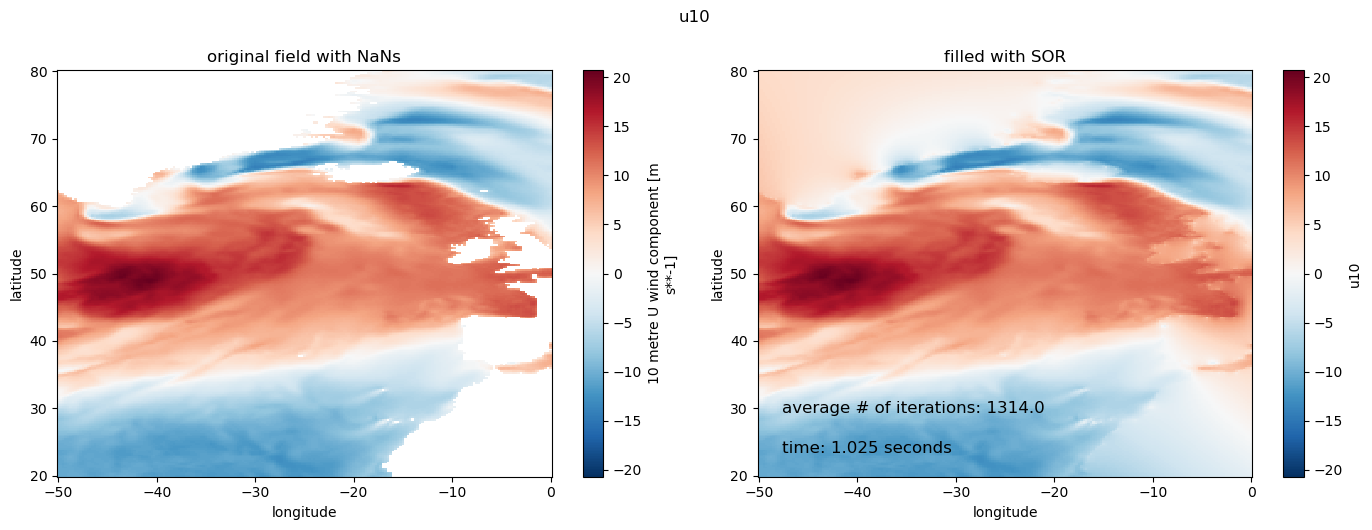

In [37]:
fig = comparison_plot("u10")

201
213
223
229
238
247
249
254
252
246


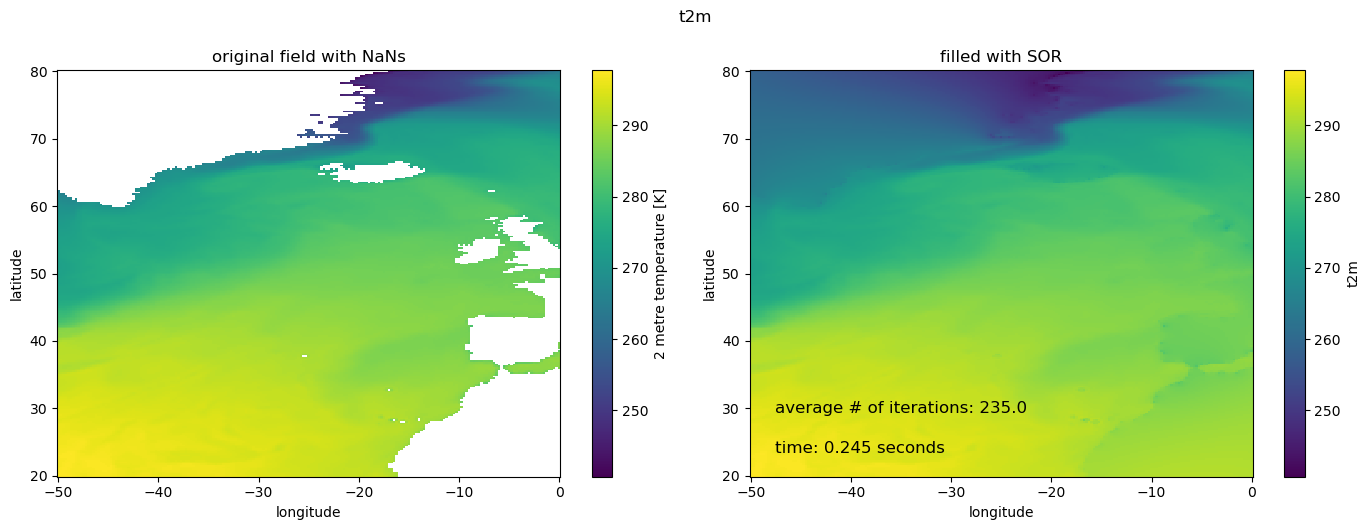

In [38]:
fig = comparison_plot("t2m")